In [1]:
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt
from glob import glob 
import os
import re
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import sem
import seaborn as sns
from skimage.measure import regionprops_table,regionprops

## 1. Sum area over time plotted for a single condition

In [4]:
#Input path & sorting files
input_path =  r"E:\Code\Growth assay\data\SumArea\TSB"
output_directory = r"F:\Code\Growth assay\data"
image_files = sorted(glob(input_path))

print(image_files)

[]


In [5]:
image_files = sorted(glob(os.path.join(input_path, '*.tif')))
dfs = []

#Combining image files into a single dataframe

for i, image_file in enumerate(image_files):
    img = io.imread(image_file, as_gray=True)
    df = pd.DataFrame(regionprops_table(img, properties=['label','area', 'eccentricity']))
    df['frame'] = i
    dfs.append(df)
    
df = pd.concat(dfs)

# Remove hash below to save dataframe as single .csv
#df.to_csv('H:\Code\Growth assay\data\df.csv', index=False)

df.groupby('frame')['area'].apply(sum)

ValueError: No objects to concatenate

In [7]:
# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='frame', y=single, data=single, ci=None)

# Set plot labels and title
plt.xlabel('Hours')
plt.ylabel('Mean Sum of Area')
plt.title('Mean Sum of Area Over Time')

print(results)

# Show the legend and plot
plt.savefig(f'{output_directory}/SumAreaPlotSingle.png', bbox_inches='tight', dpi=500)
plt.legend()
plt.show()

NameError: name 'single' is not defined

<Figure size 1000x600 with 0 Axes>

## 2. Sum Area Over Time for Multiple Conditions

In [2]:
parent_directory = r"F:\Code\Growth assay\data\SumArea"
output_directory = r"F:\Code\Growth assay\data"

# Get a list of folders in the parent directory
folders = os.listdir(parent_directory)

print(folders)

results = pd.DataFrame()

# Iterate through each folder
for folder in folders:
    # Construct the full path to the folder
    folder_path = os.path.join(parent_directory, folder)

    # Get a list of TIFF files in the folder
    image_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    dfs = []

    # Iterate through each TIFF file in the folder
    for i, image_file in enumerate(image_files):
        img = io.imread(image_file, as_gray=True).astype(int)
        df = pd.DataFrame(regionprops_table(img, properties=['label', 'area',]))
        df['frame'] = i
        dfs.append(df)

    df_folder = pd.concat(dfs)

    # Group by frame and calculate the sum of area for each frame
    temp = df_folder.groupby('frame')['area'].apply(sum)

    # Save the results to a CSV file for each folder
    df_folder.to_csv(os.path.join(folder_path, 'df.csv'), index=False)

    # Add a new column for the folder name
    temp = temp.reset_index()
    temp['folder'] = folder

    # Append the results to the overall DataFrame
    results = pd.concat([results, temp], ignore_index=True)
    
# Normalize based on their t=0 area size
results['normalized_area'] = results.groupby('folder')['area'].transform(lambda x: x / x.iloc[0])

#print(results)

# You can change these colours if you want
colors = ['#41b6c4', '#a1dab4', '#2c7fb8', '#253494']

# Plot using Seaborn
sns.set(style="darkgrid")  
plt.figure(figsize=(5, 3))
sns.lineplot(x='frame', y='normalized_area', hue='folder', data=results, ci=None, palette = colors)

# Set plot labels and title
plt.xlabel('Hours')
plt.ylabel('Normalised Mean Sum of Area')
plt.title('Mean Sum of Area Over Time')
plt.legend(title='Medium', title_fontsize = 8, fontsize=6)

# Show the legend and plot
plt.savefig(f'{output_directory}/SumAreaPlot.png', bbox_inches='tight', dpi=500)
plt.legend()
plt.show()

NameError: name 'os' is not defined

## 3. Attribution of phenotypes using eccentricity values

In [3]:
input_path =  r"F:\Code\Growth assay\data\Eccentricity\SC D-Mannitol"
output_directory = r"F:\Code\Growth assay\data/Eccentricity"
image_files = sorted(glob(input_path))

print(image_files)

image_files = sorted(glob(os.path.join(input_path, '*.tif')))

dfs = []

#Combines image files into a single dataframe

for i, image_file in enumerate(image_files):
    img = io.imread(image_file, as_gray=True)
    df = pd.DataFrame(regionprops_table(img, properties=['label','area', 'eccentricity']))
    df['frame'] = i
    dfs.append(df)
    
df = pd.concat(dfs)

#Attribution of phenotype (based on work Sander & Thomas), (yeastlike, pseudohyphae, hyphae) as a column to dataframe

phenotype = []

for i in df['eccentricity']:
    if i > 0.95:
        phenotype.append("hyphae")
    elif i > 0.85 and i < 0.96:
        phenotype.append("pseudohyphae")
    elif i < 0.86:
        phenotype.append("yeastlike")

df['phenotype'] = phenotype

NameError: name 'glob' is not defined

### Plotting the distribution of eccentricity for selected frames

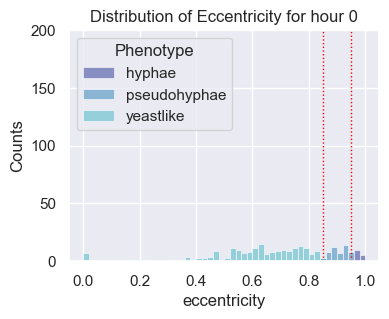

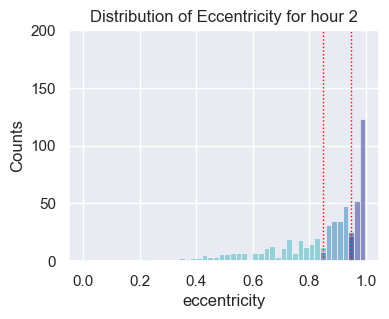

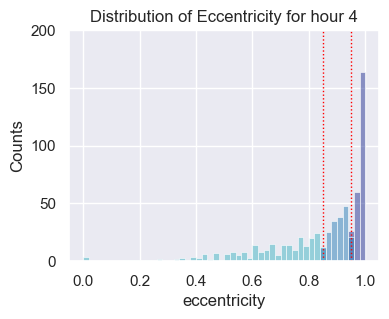

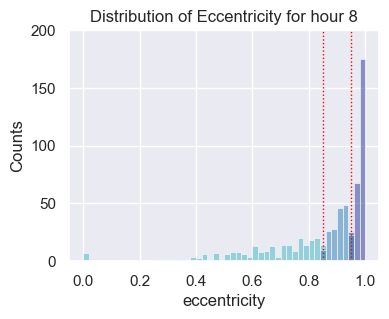

In [27]:
from importlib import reload
reload(plt)

# Frames (timestamps) to include in the plots
frames_to_include = [0, 2, 4, 8]

# You can change this color palette for the phenotypes
palette = {'yeastlike': '#41b6c4', 'pseudohyphae': '#2c7fb8', 'hyphae': '#253494'}
test = 'hyphae', 'pseudohyphae', 'yeastlike'

for frame in frames_to_include:
    # Filter the DataFrame to include only data for the current frame
    df_frame = df[df['frame'] == frame]

    plt.figure(figsize=(4, 3))

    # Plot histogram of eccentricity values with different colors for each phenotype
    sns.histplot(data=df_frame, x='eccentricity', bins=50, stat='count', hue='phenotype', palette=palette, legend=False, common_norm=True)
    plt.ylim(0, 200)
    plt.ylabel('Counts')
    plt.title(f'Distribution of Eccentricity for hour {frame}')
    plt.grid(True)
    if frame == 0:
        plt.legend(title='Phenotype', labels=test)
        
    #Adds red dotted line to highlight phenotype cut-offs
    plt.axvline(x=0.85, color='red', linestyle=':', linewidth=1)
    plt.axvline(x=0.95, color='red', linestyle=':', linewidth=1)
    plt.savefig(f'{output_directory}/EccentricityDensity{frame}.png', bbox_inches='tight', dpi=500)
    plt.show()

### Plotting the phenotype area over time

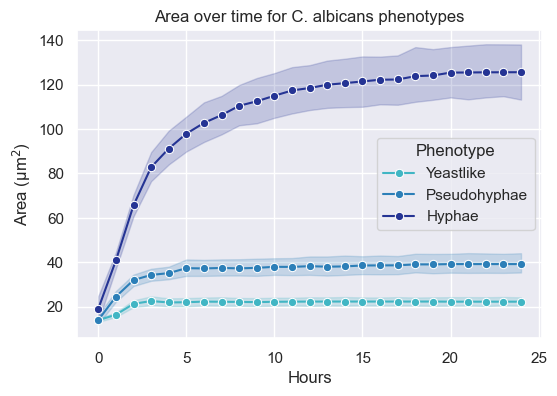

In [29]:
# Define the pixel size in microns
pixel_size_micron = 0.43  # Assuming 1 pixel = 0.43 micron

# Define the colors and markers for each phenotype
colors = ['#41b6c4', '#2c7fb8', '#253494']
markers = ['o','o','o' ]

# Create a single plot for all phenotypes
plt.figure(figsize=(6, 4))

# Loop through phenotypes to create line plots
for phenotype, color, marker in zip(['yeastlike', 'pseudohyphae', 'hyphae'], colors, markers):
    phenotype_df = df[df['phenotype'] == phenotype].reset_index(drop=True)
    phenotype_df['area_micron_squared'] = phenotype_df['area'] * (pixel_size_micron ** 2)  # Convert area to square microns
    sns.lineplot(data=phenotype_df, x='frame', y='area_micron_squared', color=color, label=phenotype, marker=marker)

# Manually adjust the legend outside the loop
legend_labels = ['Yeastlike', 'Pseudohyphae', 'Hyphae']
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, legend_labels, title='Phenotype')

plt.xlabel('Hours')
plt.ylabel('Area (µm$^2$)')
plt.title('Area over time for C. albicans phenotypes')

plt.savefig(f'{output_directory}/AreaOverTime.png', bbox_inches='tight', dpi=500)

plt.show()

### Plotting phenotype ratios over time

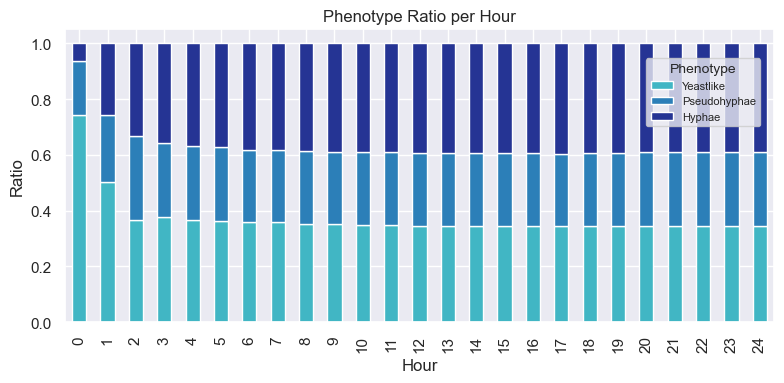

In [37]:
#Stacked barplots to show the change of yeast/pseudo/hyphae over time

import matplotlib.pyplot as plt
import pandas as pd

# Group by frame and phenotype, and calculate the count for each combination
grouped_df = df.groupby(['frame', 'phenotype']).size().unstack().fillna(0)

# Calculate the ratio for each phenotype
grouped_df['yeastlike_ratio'] = grouped_df['yeastlike'] / (grouped_df['yeastlike'] + grouped_df['pseudohyphae'] + grouped_df['hyphae'])
grouped_df['pseudohyphae_ratio'] = grouped_df['pseudohyphae'] / (grouped_df['yeastlike'] + grouped_df['pseudohyphae'] + grouped_df['hyphae'])
grouped_df['hyphae_ratio'] = grouped_df['hyphae'] / (grouped_df['yeastlike'] + grouped_df['pseudohyphae'] + grouped_df['hyphae'])

# Plot stacked barplots with ratio numbers for each frame
frames = grouped_df.index
num_frames = len(frames)

fig, ax = plt.subplots(figsize=(8, 4))

ratios = grouped_df[['yeastlike_ratio', 'pseudohyphae_ratio', 'hyphae_ratio']]
ratios_percent = ratios * 100  # Convert ratios to percentages

#Colors
colors = ['#41b6c4', '#2c7fb8', '#253494']

ratios.plot(kind='bar', stacked=True, color=colors, ax=ax)
ax.set_ylabel('Ratio')
ax.set_xlabel('Hour')

ax.set_title('Phenotype Ratio per Hour')
legend = plt.legend(title='Phenotype', title_fontsize=10, fontsize=8, bbox_to_anchor=(0.9, 0.92), loc='upper center')

legend.get_texts()[0].set_text('Yeastlike')
legend.get_texts()[1].set_text('Pseudohyphae')
legend.get_texts()[2].set_text('Hyphae')

plt.savefig(f'{output_directory}/RatioOverTime.png', bbox_inches='tight', dpi=500)
plt.tight_layout()
plt.show()


### Cell masks with eccentricity attributed

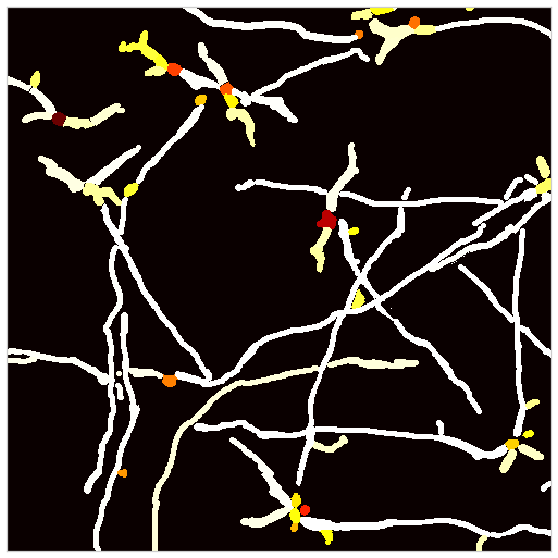

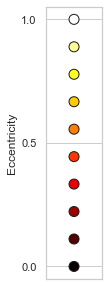

In [93]:
img = io.imread("H:\Code\Growth assay\data\Eccentricity\SC D-Mannitol\ANALYSES0020_done.tif")

#Select required timeframe
hour = 10

#Change colour scheme
them_colors = 'hot'

img_temp = np.zeros_like(img).astype(float)
for p in regionprops(img):
    img_temp[img==p.label] = p.eccentricity

fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(img_temp, interpolation='none', cmap=them_colors)
# plt.colorbar()

ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig(f'H:\Code\Growth assay\data/CellsEccentricity{hour}.png', bbox_inches='tight', dpi=500)
plt.show()

x = np.linspace(0,1,10)

fig, ax = plt.subplots(figsize=(1,5))
plt.scatter([.5]*len(x), x , c=x, cmap=them_colors, edgecolors='k', s=100)
plt.yticks([0,.5,1])
plt.xticks([]);
plt.ylabel("Eccentricity")

plt.savefig(f'H:\Code\Growth assay\data\CellsEccentricityScale{hour}.png', bbox_inches='tight', dpi=500)
